# Assignment

Goal: Bulid a multilingual Named Entity Model which can deal with english, french, italian and german text data. The model is based on neural network architechture with Tensorflow library.

Dataset: Polygot-NER from huggingface, which contains sentences with four different NER tags: 'O', 'PER', 'LOC', 'ORG'. The dataset is available through this link: https://huggingface.co/datasets/polyglot_ner

The flow of this code is as follows:
 1. Downloading data from huggingface
 2. Preprocessing data: Tokenization and Word Embedding
 3. Buliding neural network model
 4. Evaluating the model performance
 5. Visualize the model prediction


# Import libraries and download data

In [6]:
pip install datasets

In [7]:
# Import packages
from datasets import load_dataset
from collections import defaultdict
from datasets import DatasetDict
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import spacy
from spacy import displacy
import itertools
from IPython.core.display import display, HTML

We first download the data from huggingface and make a dictionary that contains english, french, german and italian dataset. For each languages it contain id, language, words and NER as keys.

In [8]:
# retrieve multilingual dataset
def get_multilingual_dataset(langs):
    panx_ch = defaultdict(DatasetDict)

    for lang in langs:
        # Load polyglot_ner dataset for the specified language
        ds = load_dataset("polyglot_ner", name=lang,split="train[:3%]")

        # Assign the dataset to the panx_ch dictionary
        panx_ch[lang] = ds

    return panx_ch

langs = [ 'en', 'it','fr','de']
multilingual_dataset = get_multilingual_dataset(langs)


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for polyglot_ner contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/polyglot_ner
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/418411 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/547578 [00:00<?, ? examples/s]

In [9]:
# Access the first example in the English dataset
element = multilingual_dataset["en"][0]
for key, value in element.items():
    print(f"{key}: {value}")

id: 0
lang: en
words: ['The', 'basilikon', '(', ',', '"', 'imperial', '[', 'coin', ']', '"', ')', ',', 'commonly', 'also', 'referred', 'to', 'as', 'the', 'doukaton', '(', 'Greek', ':', 'δουκάτον', ')', ',', 'was', 'a', 'widely', 'circulated', 'Byzantine', 'silver', 'coin', 'of', 'the', 'first', 'half', 'of', 'the', '14th', 'century', '.']
ner: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


We can also check the number of sentences that is included for each languages.

In [10]:
multilingual_dataset

defaultdict(datasets.dataset_dict.DatasetDict,
            {'en': Dataset({
                 features: ['id', 'lang', 'words', 'ner'],
                 num_rows: 12719
             }),
             'it': Dataset({
                 features: ['id', 'lang', 'words', 'ner'],
                 num_rows: 11350
             }),
             'fr': Dataset({
                 features: ['id', 'lang', 'words', 'ner'],
                 num_rows: 12552
             }),
             'de': Dataset({
                 features: ['id', 'lang', 'words', 'ner'],
                 num_rows: 16427
             })})

We then make the dictionary into pandas dataframe format by combining the words into sentences and NER tags. We also shuffle all the sentences so that the model learns the languages in a random order.

In [11]:
def create_combined_sentences_dataframe(dataset):
    data = {'Language': [], 'Combined_Sentence': [], 'NER': []}

    for lang, lang_dataset in dataset.items():
        sentences = lang_dataset['words']
        ner_labels = lang_dataset['ner']

        for sentence, ner_label in zip(sentences, ner_labels):
            combined_sentence = ' '.join(sentence)
            data['Language'].append(lang)
            data['Combined_Sentence'].append(combined_sentence)
            data['NER'].append(ner_label)

    df = pd.DataFrame(data)

    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    return df

# Create multilingual dataframe
df_combined_sentences = create_combined_sentences_dataframe(multilingual_dataset)

# Display the DataFrame
df_combined_sentences.head()

,Language,Combined_Sentence,NER
0,it,"Quando Trujillo salì al potere , la loro famig...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,fr,Carrière Rodney Soher participe aux Jeux olymp...,"[O, PER, PER, O, O, O, O, O, O, O, LOC, O, O, ..."
2,it,Nell'aprile 2013 sostituisce per una settimana...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,fr,Biographie Carrière Filmographie Lien externe,"[O, O, O, O, O]"
4,en,References External links,"[O, O, O]"


In [12]:
# Create a function that defines X (sentence) and Y (NER) from given dataset
def df_to_XY(data):
    X =  list(data['Combined_Sentence'])
    Y = list(data['NER'])
    return X,Y

X, Y = df_to_XY(df_combined_sentences)

In [13]:
print("First three sentences: \n")
print(X[:3])

print("Corresponding NERs: \n")
print(Y[:3])

First three sentences: 

['Quando Trujillo salì al potere , la loro famiglia ( come molte altre nel paese ) perse quasi totalmente i propri beni , prima nazionalizzati , poi incamerati direttamente dal dittatore nei suoi beni privati .', "Carrière Rodney Soher participe aux Jeux olympiques de 1924 à Chamonix et remporte la médaille d'argent en bob à quatre , avec Thomas Arnold , Alexander Richardson et Ralph Broome .", "Nell'aprile 2013 sostituisce per una settimana Linus e Nicola Savino a Deejay chiama Italia , in coppia con Vic ."]
Corresponding NERs: 

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'PER', 'PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PER', 'PER', 'O', 'PER', 'PER', 'O', 'PER', 'PER', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

# Tokenizing and word embedding padding
We tokenize the sentences and map each word to a unique identifier, then pad them because neural network need the input sentences to have the same length. We limit the input vector to have a maximum length of 120 and model to memorize up to 150000 unique words.


In [14]:
# Define a function that tokenizes and numericalize the sentence and returns dictionary that matches word to index and vice versa
def token_index(X, maxlen,max_words):

    '''Returns tokenized and numericalized sentences and dictionaries '''

    # Tokenize each sentence in the dataset
    tokenizer = Tokenizer(num_words = max_words)
    tokenizer.fit_on_texts(X)
    # Create a unique number for each words
    sequences = tokenizer.texts_to_sequences(X)
    word_index = tokenizer.word_index
    print("Found {} unique tokens.".format(len(word_index)))

    # Define word index (words to unique numbers)
    word2id = word_index
    # Also create a dictionary that combines unique numbers to words
    id2word = {}
    for key, value in word2id.items():
        id2word[value] = key
    return sequences, word2id, id2word

########## Parameters ##########
# Set the maximum length of the sentence to 120
maxlen = 120
maxwords = 150000

sequences, word2id, id2word = token_index(X,maxlen,maxwords)

# Pad the sequences so that all sequences are of the same size
X_preprocessed = pad_sequences(sequences, maxlen=maxlen, padding='post')
# Note that now all the sentences have same length (120 words)
len(X_preprocessed[0]), len(X_preprocessed[1])

Found 137339 unique tokens.


(120, 120)

According to the polygot-NER documentation there is four different entities: Location(LOC), Organization(ORG), Person(PER) and Nonentity(O). We assigned unique numbers to each entity to make sure that the format readable for neural network.

Also, we preprocess tags by assigning a unique identifier for each tags and pad the tags by using O tag to make sure that tags for each sentences have the same length.


In [15]:
# Create dictionaries that assigns each entity to unique number and vice versa
tags2id = {
    'O' : 0,
    'LOC' : 1,
    'ORG' : 2,
    'PER' : 3
}
id2tag = {}
for key, value in tags2id.items():
    id2tag[value] = key

'''Function that function that cuts off sentences after max words and assigns unique numbers to each NER tag,
 adding O if the sentence length is less than 120 words'''

def preprocess_tags(Y, tags2id, max_length):

    # Cutoff sentences after max_length words
    Y_cut_off = [sentence[:max_length] if len(sentence) > max_length else sentence for sentence in Y]

    # Assign unique numbers to each tag using the tags2id dictionary
    Y_encoded = [[tags2id.get(tag, tags2id['O']) for tag in sentence] for sentence in Y_cut_off]

    # Pad the tags to have same length
    Y_padded = [sentence + [tags2id['O']] * (max_length - len(sentence)) for sentence in Y_encoded]


    # Convert to NumPy array
    Y_array = np.vstack(Y_padded).astype(np.int32)

    return Y_array

# Preprocess tags
Y_preprocessed = preprocess_tags(Y, tags2id, maxlen)

Now we split the preprocessed data into train (80%) and the test set (20%).

In [16]:
# Split train and test set
X_preprocessed = np.asarray(X_preprocessed)
Y_preprocessed = np.asarray(Y_preprocessed)


# 80% of the data will be used for training and validation (5-fold CV)
training_samples = 0.8
# 20% of the data will be used for testing
testing_samples = 0.2

indices = np.arange(len(Y))

X_train = X_preprocessed[: int(training_samples * len(X_preprocessed))]
print("Number of training examples: {}".format(len(X_train)))

X_test = X_preprocessed[int(training_samples * len(X_preprocessed)) + 1 : ]
print("Number of testing examples: {}".format(len(X_test)))

Y_train = Y_preprocessed[: int(training_samples * len(X))]

# Note that we use original target values (no cutoff and no padding) for test set
Y_test = Y_preprocessed[int(training_samples * len(X)) + 1 : ]

print("Total number of examples after shuffling and splitting: {}".format(len(X_train) + len(X_test)))

Number of training examples: 42438
Number of testing examples: 10609
Total number of examples after shuffling and splitting: 53047


# Model
Now we build a model which includes embedding layer with dimension size 300, two bidirectional LSTM layers and time distributed layer. The model used batch size of 100 and buffer size of 132.

In [17]:
# Initialize model
##### Parameters #####
batch_size = 100
buffer_size = 132

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(batch_size)

embedding_dim = 300
num_tags = 4 # We have 4 different entities

# Build and compile the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(maxwords, embedding_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation='softmax'))
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Call GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 300)          45000000  
                                                                 
 bidirectional (Bidirection  (None, 120, 200)          320800    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 120, 200)          240800    
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 120, 4)            804       
 ributed)                                                        
                                                                 
Total params: 45562404 (173.81 MB)
Trainable params: 45562404 (173.81 MB)
Non-trainable params: 0 (0.00 Byte)
____________

5-fold cross validation was used to assess the generalization performance of the model.

In [18]:
# Combine X_preprocessed and Y_preprocessed into a tuple
data = list(zip(X_preprocessed, Y_preprocessed))

# Define the number of folds
num_folds = 5

# Initialize lists to store results
all_train_histories = []
all_val_histories = []

# Perform k-fold cross-validation
for fold in range(num_folds):
    print(f"\nTraining fold {fold + 1}/{num_folds}")

    # Split data into train and validation sets
    fold_size = len(data) // num_folds
    val_data = data[fold * fold_size:(fold + 1) * fold_size]
    train_data = data[:fold * fold_size] + data[(fold + 1) * fold_size:]

    # Shuffle training data
    np.random.shuffle(train_data)

    # Split train_data into X_train and Y_train
    X_train, Y_train = zip(*train_data)

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((np.asarray(X_train), np.asarray(Y_train))).shuffle(buffer_size).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((np.asarray(val_data)[:, 0], np.asarray(val_data)[:, 1])).batch(batch_size)

    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(maxwords, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='tanh', return_sequences=True)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation='softmax'))
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=15)

    # Save the training and validation histories
    all_train_histories.append(history.history['accuracy'])
    all_val_histories.append(history.history['val_accuracy'])

# Print average training and validation accuracy across folds

for i in range(num_folds):
    print("For fold:",i)
    print(f"Average training accuracy is :{np.mean(all_train_histories[i])}")
    print(f"Average validation accuracy is :{np.mean(all_val_histories[i])}")



Training fold 1/5
Epoch 1/15
425/425 [==============================] - 72s 128ms/step - loss: 0.0621 - accuracy: 0.9867 - val_loss: 0.0437 - val_accuracy: 0.9889
Epoch 2/15
425/425 [==============================] - 30s 71ms/step - loss: 0.0347 - accuracy: 0.9893 - val_loss: 0.0379 - val_accuracy: 0.9890
Epoch 3/15
425/425 [==============================] - 26s 62ms/step - loss: 0.0242 - accuracy: 0.9908 - val_loss: 0.0420 - val_accuracy: 0.9890
Epoch 4/15
425/425 [==============================] - 23s 53ms/step - loss: 0.0184 - accuracy: 0.9926 - val_loss: 0.0450 - val_accuracy: 0.9884
Epoch 5/15
425/425 [==============================] - 23s 53ms/step - loss: 0.0153 - accuracy: 0.9937 - val_loss: 0.0472 - val_accuracy: 0.9882
Epoch 6/15
425/425 [==============================] - 22s 51ms/step - loss: 0.0124 - accuracy: 0.9949 - val_loss: 0.0553 - val_accuracy: 0.9888
Epoch 7/15
425/425 [==============================] - 21s 50ms/step - loss: 0.0104 - accuracy: 0.9957 - val_loss: 0.

Now we evaluate the performance of the model on the train set, and derive accuracy, F1 score and confusion matrix to see how the model well predicts on new data.

In [19]:
def evaluate_model(model, X_test, Y_test, id2word, id2tag, maxlen):
    # Initialize lists to store results
    all_true_labels = []
    all_predicted_labels = []

    # Iterate over the test set
    for i in range(len(X_test)):
        #preprocessed_sentence = tf.keras.preprocessing.sequence.pad_sequences([X_test[i]], maxlen=maxlen)
        preprocessed_sentence = X_test[i].reshape((1, maxlen))

        # Make prediction on target value
        prediction = model.predict(preprocessed_sentence,verbose=None);
        prediction = np.argmax(prediction[0], axis=1)

        # Get true target value
        true_labels = Y_test[i]

        # Store true and predicted labels
        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(prediction)

    # Calculate and print accuracy
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    print(f"Accuracy: {accuracy}")

    # Calculate and print F1 score
    f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')
    print(f"F1 Score: {f1}")

    # Calculate and print confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    return conf_matrix

# Assuming you have X_test and Y_test defined
conf_matrix = evaluate_model(model, X_test, Y_test, id2word, id2tag, maxlen)

Accuracy: 0.9872529613221479
F1 Score: 0.9863129581113316
Confusion Matrix:
[[1252957    2325    1700    2134]
 [   3696    1572      96      47]
 [   2608     106    1113      53]
 [   3403      37      23    1210]]


In [20]:
# Create a function that visualizes confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

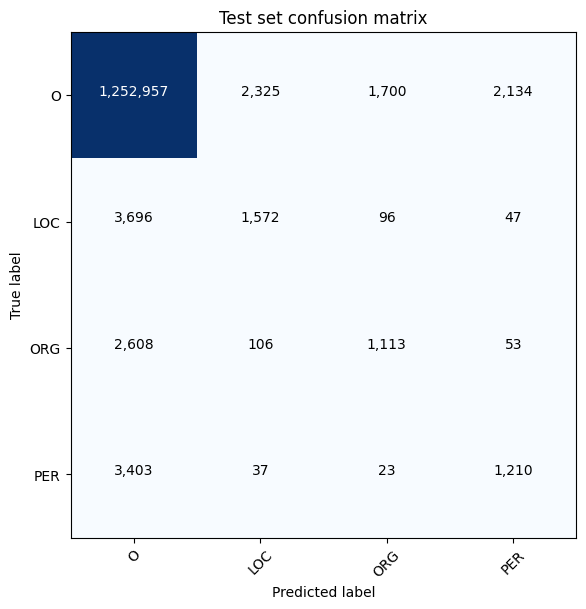

In [21]:
plot_confusion_matrix(cm           = conf_matrix,
                      normalize    = False,
                      target_names = ['O', 'LOC','ORG','PER'],
                      title        = "Test set confusion matrix")

# Visalizing results
We can also visualize the model's prediction result on the test set using library Spacy.

In [22]:
# Function that returns original sentence and predicted NER tags
def make_prediction(model, preprocessed_sentence, id2word, id2tag,maxlen):

    #if preprocessed_sentence.shape() != (1, maxlen):
    preprocessed_sentence = preprocessed_sentence.reshape((1, maxlen))

    # return preprocessed sentence to its orginal form
    sentence = preprocessed_sentence[preprocessed_sentence > 0]
    word_list = []
    for word in list(sentence):
        word_list.append(id2word[word])
    orginal_sentence = ' '.join(word_list)
    len_orginal_sentence = len(word_list)

    # make prediction
    prediction = model.predict(preprocessed_sentence,verbose=None);
    prediction = np.argmax(prediction[0], axis=1)

    # return the prediction to its orginal form
    prediction = list(prediction)[ : len_orginal_sentence]

    pred_tag_list = []
    for tag_id in prediction:
        pred_tag_list.append(id2tag[tag_id])
    return orginal_sentence,  pred_tag_list

# Function that creates dictionary where key is NER tag and value is corresponding word position
def calculate_start_end_for_words(sentence, ner_tags):
    start_end_list = []  # Initialize an empty list to store start and end positions
    start = 0  # Initialize the starting position

    for i, (word, ner) in enumerate(zip(sentence.split(), ner_tags)):

        if ner != 'O':
            start = sentence.find(word) # Record the starting position
            end = start + len(word)  # Record the ending position
            start_end_list.append({"start": start, "end": end, "label": ner})

    return start_end_list


# Function that visualizes predicted NER tags for given text
def visualization(model, number ,id2word, id2tag,maxlen):
  # Retrieve random sentences from test set
  random.seed(8) # Fix the result
  rnumber = [random.randint(0,X_test.shape[0]) for x in range(number)]

  for index in rnumber:
    preprocessed_sentence = X_test[index]
    # Predict on given sentence
    original_sentence,  pred_tag_list = make_prediction(model, preprocessed_sentence, id2word, id2tag,maxlen)
    # Create a dictionary that is needed for Spacy visualization
    dic_ents = {
    "text": original_sentence,
    "ents": calculate_start_end_for_words(original_sentence,  pred_tag_list),
    "title": None
    }
    html = displacy.render(dic_ents, manual=True, style="ent")
    display(HTML(html))

visualization(model,10,id2word, id2tag,maxlen)